In [10]:
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta 
import numpy as np 
from scipy.optimize import minimize

In [11]:
tickers = ['SPY','NVDA','AAPL','MSFT','AMD', 'GOOGL', 'AMZN', 'TSLA', 'MU']
end_date = datetime.today()
start_date = end_date - timedelta(days = 365)

In [12]:
# Robust multi-ticker download with adjusted prices and MultiIndex handling
raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,           # adjusted already lives in 'Close'
    group_by="column",
    progress=False
)

# Extract adjusted price level for both old/new yfinance behaviors
if isinstance(raw.columns, pd.MultiIndex):
    lvl0 = raw.columns.get_level_values(0)
    want = "Adj Close" if "Adj Close" in lvl0 else "Close"
    adj_close_df = raw.xs(want, axis=1, level=0)
else:
    want = "Adj Close" if "Adj Close" in raw.columns else "Close"
    adj_close_df = raw[[want]]
    # If a single ticker was provided, rename the column to the ticker symbol
    if isinstance(tickers, list) and len(tickers) == 1:
        adj_close_df = adj_close_df.rename(columns={want: tickers[0]})

# Optional: align to business days and fill small gaps
adj_close_df = (
    adj_close_df.sort_index()
                .asfreq("B")
                .ffill(limit=3)
                .dropna(how="all")
)

print(f"Adjusted close DataFrame shape: {adj_close_df.shape}")
print(f"Columns in adj_close_df: {list(adj_close_df.columns)}")
if not adj_close_df.empty:
    print(f"Date range: {adj_close_df.index[0]} to {adj_close_df.index[-1]}")
    print(adj_close_df.head())
else:
    print("Error: No data was downloaded. Check tickers/date range/network.")

Adjusted close DataFrame shape: (261, 9)
Columns in adj_close_df: ['AAPL', 'AMD', 'AMZN', 'GOOGL', 'MSFT', 'MU', 'NVDA', 'SPY', 'TSLA']
Date range: 2024-08-16 00:00:00 to 2025-08-15 00:00:00
Ticker       AAPL    AMD   AMZN  GOOGL   MSFT     MU   NVDA    SPY   TSLA
Date                                                                     
2024-08-16 225.00 148.56 177.06 162.17 416.03 107.49 124.54 547.49 216.12
2024-08-19 224.84 155.28 178.22 165.87 419.08 108.12 129.96 552.73 222.72
2024-08-20 225.46 156.40 178.88 166.37 422.33 107.49 127.21 551.83 221.10
2024-08-21 225.35 157.81 180.11 165.05 421.67 107.83 128.46 553.72 223.27
2024-08-22 223.49 151.70 176.13 163.01 413.13 103.77 123.70 549.38 210.66


Market-value weights (based on latest prices):
Ticker
AAPL    0.11
AMD     0.03
AMZN    0.01
GOOGL   0.04
MSFT    0.23
MU      0.06
NVDA    0.49
TSLA    0.03
dtype: float64

Holdings summary:
       quantity  avg_price  last_price  market_value  cost_basis  \
AAPL        105     217.00      231.59     24,316.95   22,785.00   
AMD          30     130.51      177.51      5,325.30    3,915.21   
AMZN          9     162.52      231.03      2,079.27    1,462.68   
GOOGL        40     160.56      203.90      8,156.00    6,422.36   
MSFT         95     413.80      520.17     49,416.15   39,310.62   
MU          100     132.76      120.87     12,087.00   13,276.00   
NVDA        580     123.03      180.45    104,661.00   71,359.72   
TSLA         19     259.10      330.56      6,280.64    4,922.88   

       unrealized_pnl  unrealized_pct  
AAPL         1,531.95            6.72  
AMD          1,410.09           36.02  
AMZN           616.59           42.15  
GOOGL        1,733.64           26.

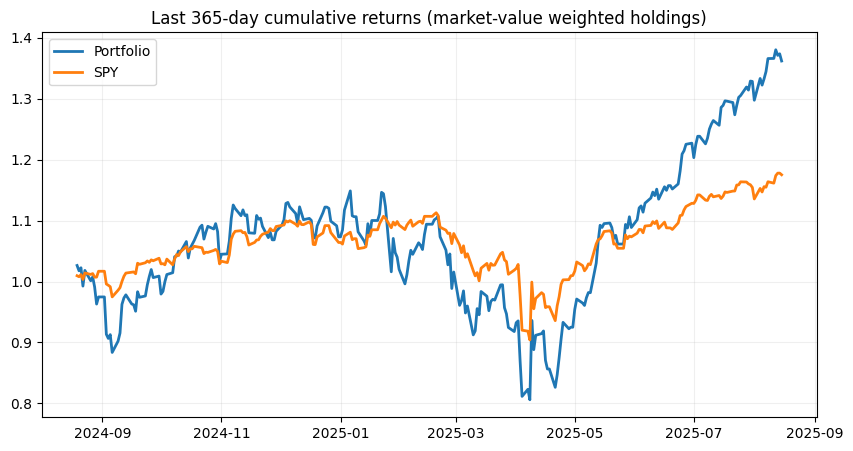

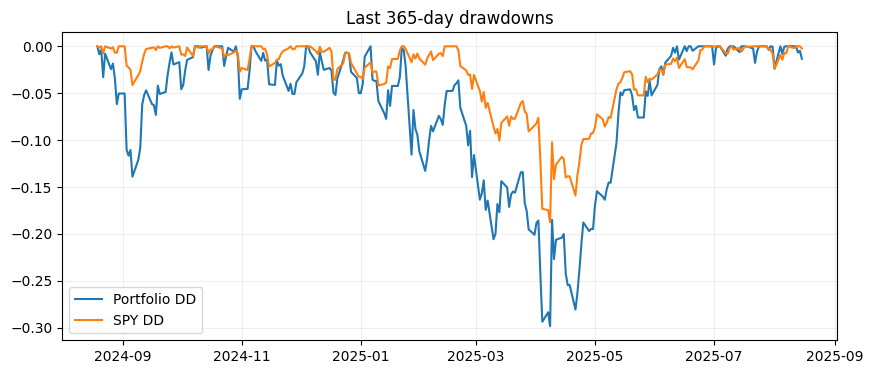


Exported `portfolio_from_holdings` dict (windowed + cost basis).


In [14]:
holdings = {
    'AAPL': 105,
    'AMD': 30,
    'AMZN': 9,
    'GOOGL': 40,
    'MSFT': 95,
    'MU': 100,
    'NVDA': 580,
    'TSLA': 19,
}

# --- Average purchase prices (fill from your broker screenshots) ---
avg_prices = {
    'AAPL': 217.000,
    'AMD': 130.507,
    'AMZN': 162.520,
    'GOOGL': 160.559,
    'MSFT': 413.796,
    'MU': 132.760,
    'NVDA': 123.034,
    'TSLA': 259.099,
}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from datetime import datetime

# Ensure price index exists
try:
    prices = adj_close_df.copy()
except NameError:
    raise RuntimeError('adj_close_df not available in notebook; run your data download/processing cells first.')

# Make sure all tickers are in prices, otherwise download missing ones
miss = [t for t in holdings.keys() if t not in prices.columns]
if miss:
    print('Downloading missing tickers:', miss)
    data = yf.download(miss, start=prices.index.min(), end=prices.index.max(), progress=False, auto_adjust=True)
    if isinstance(data.columns, pd.MultiIndex):
        close = data.xs('Close', axis=1, level=1)
    else:
        close = data['Close'] if 'Close' in data.columns else data
    for t in miss:
        if t in close.columns:
            prices[t] = close[t].reindex(prices.index).ffill()

# Ensure SPY benchmark
benchmark = 'SPY'
if benchmark not in prices.columns:
    spy = yf.download(benchmark, start=prices.index.min(), end=prices.index.max(), progress=False, auto_adjust=True)
    prices[benchmark] = spy['Close'].reindex(prices.index).ffill()

# --- Time window: 1 year (configurable) ---
LOOKBACK_DAYS = 365  # set to 365 for one year; change to 252 for trading days
window_start = pd.Timestamp(datetime.today().date()) - pd.Timedelta(days=LOOKBACK_DAYS)
prices_window = prices.loc[prices.index >= window_start]
if prices_window.empty:
    # Fallback: use full available history
    print(f'No data for last {LOOKBACK_DAYS} days starting {window_start.date()}; falling back to full available range')
    prices_window = prices.copy()

# Use most recent prices for market-value (current value)
last_prices = prices.iloc[-1][list(holdings.keys())]
quantities = pd.Series(holdings)
market_values = last_prices * quantities
weights = market_values / market_values.sum()
print('Market-value weights (based on latest prices):')
print(weights.round(4))

# Build avg_prices Series (ensure alignment)
avg_prices_series = pd.Series(avg_prices)
# If any avg price missing, fill with NaN
for t in holdings.keys():
    if t not in avg_prices_series:
        avg_prices_series[t] = np.nan
avg_prices_series = avg_prices_series[list(holdings.keys())]

# Cost basis and unrealized P/L
cost_basis = avg_prices_series * quantities
unrealized_pnl = market_values - cost_basis
unrealized_pct = (last_prices / avg_prices_series - 1.0) * 100.0

# Summary table per holding
holdings_df = pd.DataFrame({
    'quantity': quantities,
    'avg_price': avg_prices_series,
    'last_price': last_prices,
    'market_value': market_values,
    'cost_basis': cost_basis,
    'unrealized_pnl': unrealized_pnl,
    'unrealized_pct': unrealized_pct
})
# Nicely format
pd.options.display.float_format = '{:,.2f}'.format
print('\nHoldings summary:')
print(holdings_df)

# Compute returns over the chosen window and run analysis
rets = prices_window[list(holdings.keys()) + [benchmark]].pct_change().dropna(how='all')
# Align dates where benchmark exists
rets = rets.loc[~rets[benchmark].isna()]
port_rets = (rets[list(holdings.keys())] * weights.values).sum(axis=1)
bench_rets = rets[benchmark]

# Align
idx = port_rets.index.intersection(bench_rets.index)
port_rets = port_rets.loc[idx]
bench_rets = bench_rets.loc[idx]

cum_port = (1+port_rets).cumprod()
cum_bench = (1+bench_rets).cumprod()

excess = port_rets - bench_rets
tracking_error = excess.std(ddof=1) * np.sqrt(252)
active_return = excess.mean() * 252
information_ratio = active_return / tracking_error if tracking_error>0 else np.nan

mask = np.isfinite(port_rets) & np.isfinite(bench_rets)
if mask.sum() < 10:
    beta = np.nan
    alpha = np.nan
else:
    slope, intercept, r_value, p_value, std_err = stats.linregress(bench_rets[mask], port_rets[mask])
    beta = float(slope)
    alpha = float(intercept * 252)

# Drawdowns
def drawdown(s):
    rm = s.cummax()
    return (s - rm) / rm

dd_port = drawdown(cum_port)
dd_bench = drawdown(cum_bench)

# Totals
total_market_value = market_values.sum()
total_cost_basis = cost_basis.sum()
total_unrealized = unrealized_pnl.sum()

# Print results
print('\nPortfolio market value: ${:,.2f}'.format(total_market_value))
print('Total cost basis: ${:,.2f}'.format(total_cost_basis))
print('Unrealized P&L: ${:,.2f} ({:+.2f}%)'.format(total_unrealized, (total_unrealized/total_cost_basis)*100 if total_cost_basis>0 else np.nan))
print(f'Window start: {window_start.date()} to {idx[-1].date()} (last {LOOKBACK_DAYS} days)')
print('Portfolio window return (approx): {:.2%}'.format((cum_port.iloc[-1] - 1)))
print('Benchmark window return (approx): {:.2%}'.format((cum_bench.iloc[-1] - 1)))
print('Tracking error (ann): {:.4f}'.format(tracking_error))
print('Active return (ann): {:.4f}'.format(active_return))
print('Information ratio: {:.4f}'.format(information_ratio))
print('Beta: {:.4f}'.format(beta))

# Plots
plt.figure(figsize=(10,5))
plt.plot(cum_port, label='Portfolio', lw=2)
plt.plot(cum_bench, label=benchmark, lw=2)
plt.legend()
plt.grid(alpha=0.2)
plt.title(f'Last {LOOKBACK_DAYS}-day cumulative returns (market-value weighted holdings)')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(dd_port, label='Portfolio DD')
plt.plot(dd_bench, label=benchmark + ' DD')
plt.legend()
plt.grid(alpha=0.2)
plt.title(f'Last {LOOKBACK_DAYS}-day drawdowns')
plt.show()

# expose
holdings_weights = weights
portfolio_from_holdings = dict(
    holdings=holdings,
    quantities=quantities,
    avg_prices=avg_prices_series,
    weights=weights,
    market_values=market_values,
    cost_basis=cost_basis,
    unrealized_pnl=unrealized_pnl,
    unrealized_pct=unrealized_pct,
    total_market_value=total_market_value,
    total_cost_basis=total_cost_basis,
    total_unrealized=total_unrealized,
    portfolio_returns=port_rets,
    benchmark_returns=bench_rets,
    cum_port=cum_port,
    cum_bench=cum_bench,
    tracking_error=tracking_error,
    information_ratio=information_ratio,
    beta=beta,
    drawdown_port=dd_port,
    drawdown_bench=dd_bench,
    window_start=window_start,
    lookback_days=LOOKBACK_DAYS
)
print('\nExported `portfolio_from_holdings` dict (windowed + cost basis).')
